## **IMPORTING THE LIBRARIES**





In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### **IMPORTING THE DATASET**

In [5]:
dataset=pd.read_csv('placedata v2.0 synthetic.csv')


In [6]:
dataset.head()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


### **Data Pre Processing**

In [7]:
if 'StudentID' in dataset.columns:
    dataset = dataset.drop('StudentID', axis=1)

Encode Categorical Variables & Target

In [9]:

from sklearn.preprocessing import LabelEncoder, StandardScaler

le_status = LabelEncoder()
le_extra = LabelEncoder()
le_training = LabelEncoder()

dataset['PlacementStatus'] = le_status.fit_transform(dataset['PlacementStatus'])
dataset['ExtracurricularActivities'] = le_extra.fit_transform(
    dataset['ExtracurricularActivities']
)
dataset['PlacementTraining'] = le_training.fit_transform(
    dataset['PlacementTraining']
)

Separate Features & Target

In [10]:
X = dataset.drop('PlacementStatus', axis=1)
y = dataset['PlacementStatus']

Train-Test Split (No Data Leakage)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)


In [50]:
X_train.shape

(8000, 10)

In [48]:
X_test.shape

(2000, 10)

checking for null values

In [14]:
dataset.isna().sum()

,0
CGPA,0
Internships,0
Projects,0
Workshops/Certifications,0
AptitudeTestScore,0
SoftSkillsRating,0
ExtracurricularActivities,0
PlacementTraining,0
SSC_Marks,0
HSC_Marks,0


Feature scaling

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
dataset['CGPA_Aptitude'] = dataset['CGPA'] * dataset['AptitudeTestScore']
dataset['SoftSkills_Extracurricular'] = dataset['SoftSkillsRating'] + dataset['ExtracurricularActivities']

### **DATA VISUALIZATION**

In [18]:
dataset.describe()

,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus,CGPA_Aptitude,SoftSkills_Extracurricular
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.698010,1.049200,2.026600,1.013200,79.449900,4.323960,0.585400,0.731800,69.159400,74.501500,0.419700,614.015210,4.909360
std,0.640131,0.665901,0.867968,0.904272,8.159997,0.411622,0.492677,0.443044,10.430459,8.919527,0.493534,97.140501,0.770642
min,6.500000,0.000000,0.000000,0.000000,60.000000,3.000000,0.000000,0.000000,55.000000,57.000000,0.000000,390.000000,3.000000
25%,7.400000,1.000000,1.000000,0.000000,73.000000,4.000000,0.000000,0.000000,59.000000,67.000000,0.000000,537.200000,4.200000
50%,7.700000,1.000000,2.000000,1.000000,80.000000,4.400000,1.000000,1.000000,70.000000,73.000000,0.000000,613.650000,5.100000
75%,8.200000,1.000000,3.000000,2.000000,87.000000,4.700000,1.000000,1.000000,78.000000,83.000000,1.000000,697.200000,5.600000
max,9.100000,2.000000,3.000000,3.000000,90.000000,4.800000,1.000000,1.000000,90.000000,88.000000,1.000000,819.000000,5.800000


Correlation Heat Maps

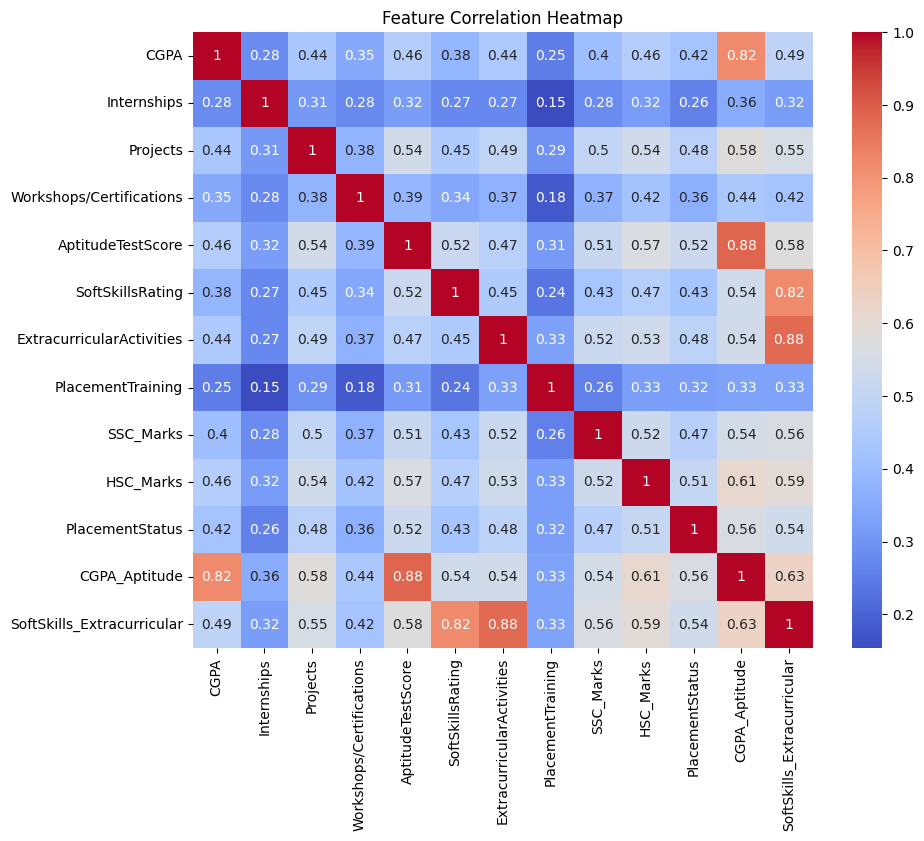

In [19]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Count Plots

/tmp/ipython-input-1890132203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='PlacementStatus', palette='Set2')


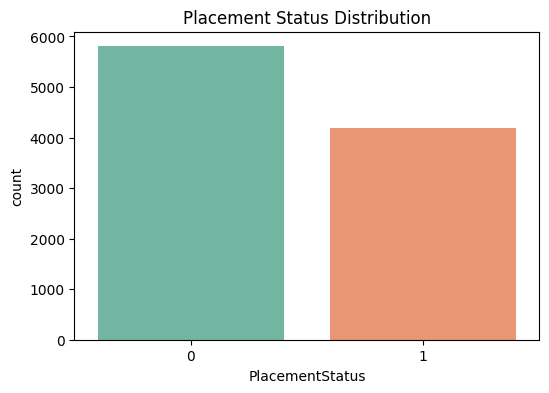

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(data=dataset, x='PlacementStatus', palette='Set2')
plt.title('Placement Status Distribution')
plt.show()


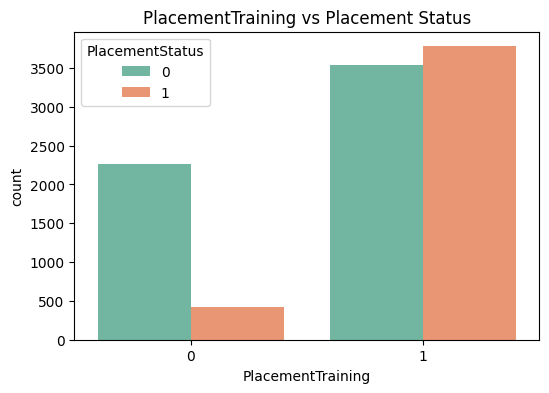

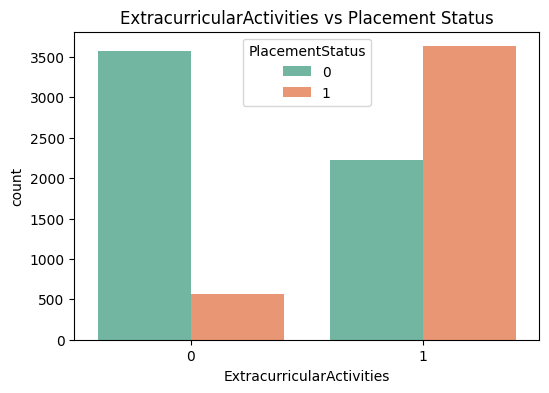

In [21]:
categorical_features = ['PlacementTraining', 'ExtracurricularActivities']

for feature in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=feature, hue='PlacementStatus', data=dataset, palette='Set2')
    plt.title(f'{feature} vs Placement Status')
    plt.show()

Boxplots for Numerical Features vs Placement

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


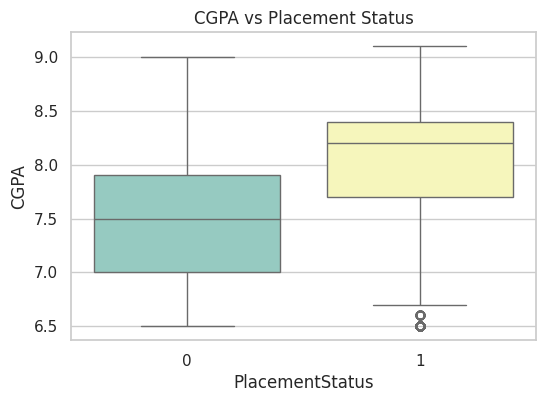

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


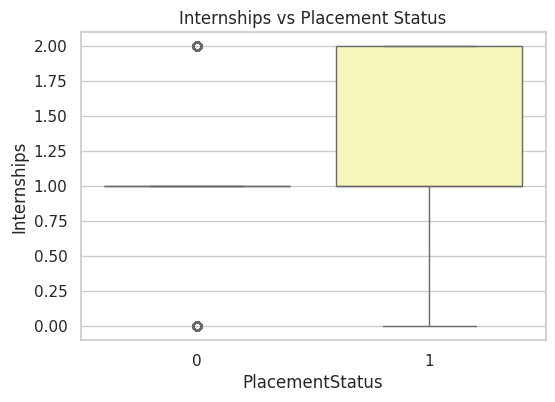

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


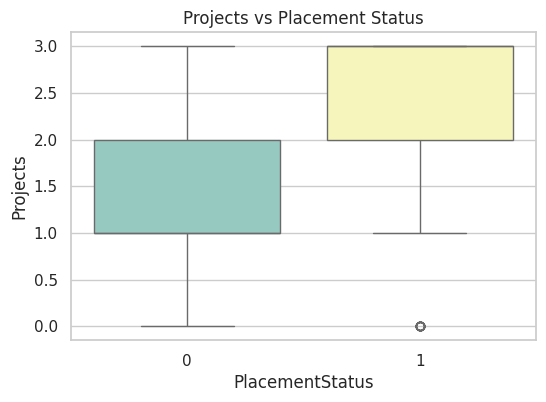

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


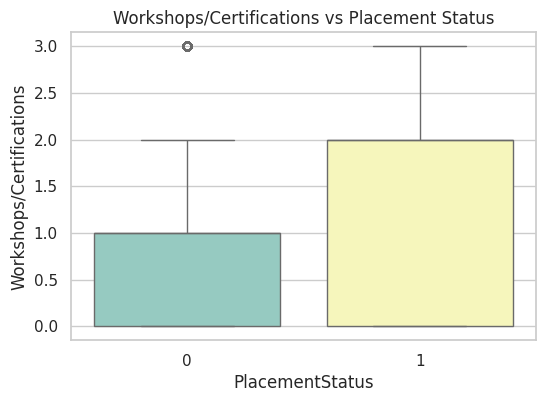

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


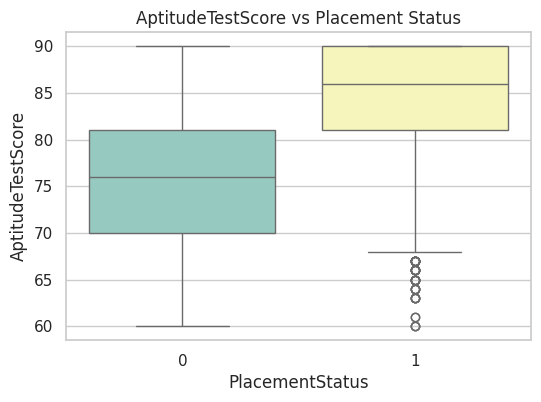

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


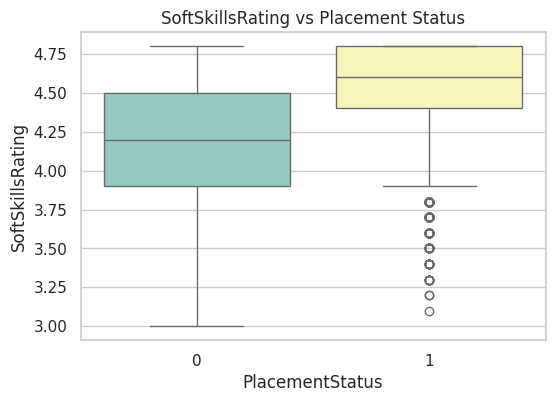

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


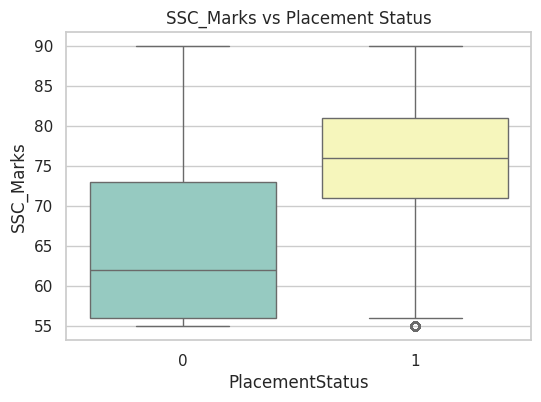

/tmp/ipython-input-2372740667.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')


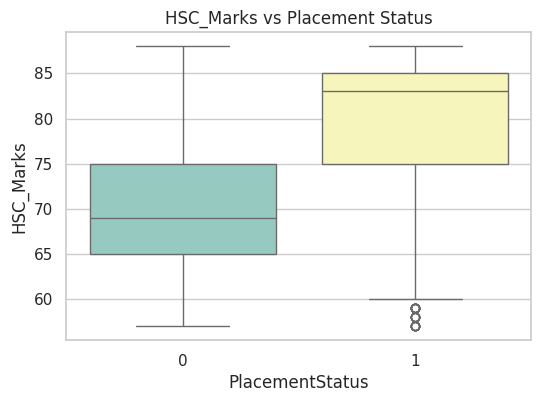

In [60]:
numerical_features = ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications',
                      'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks']

for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='PlacementStatus', y=feature, data=dataset, palette='Set3')
    plt.title(f'{feature} vs Placement Status')
    plt.show()


### **TESTING MODELS**

In [59]:
# Import required libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb



In [54]:
# List of models
models = [
    [SVC(probability=True), "Support Vector Machine"], # Added probability=True
    [LogisticRegression(C=0.1, max_iter=1000), "Logistic Regression"],
    [RandomForestClassifier(n_estimators=100, random_state=0), "Random Forest"],
    [DecisionTreeClassifier(max_depth=7, random_state=0), "Decision Tree"],
    [KNeighborsClassifier(n_neighbors=7), "K-Nearest Neighbors"],
    [xgb.XGBClassifier(objective="binary:logistic", random_state=42,eval_metric='logloss'), "XGBoost"],
    [AdaBoostClassifier(n_estimators=25, random_state=0), "AdaBoost"],
    [GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=10, random_state=0), "Gradient Boosting"]
]

# Train and evaluate each model
for model, name in models:
    print(f"--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

--- Support Vector Machine ---
--- Logistic Regression ---
--- Random Forest ---
--- Decision Tree ---
--- K-Nearest Neighbors ---
--- XGBoost ---
--- AdaBoost ---
--- Gradient Boosting ---


EVALUATION

Support Vector Machine Accuracy: 79.90%


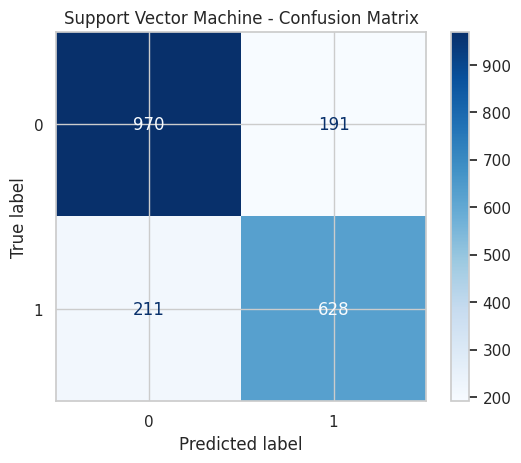



Logistic Regression Accuracy: 80.85%


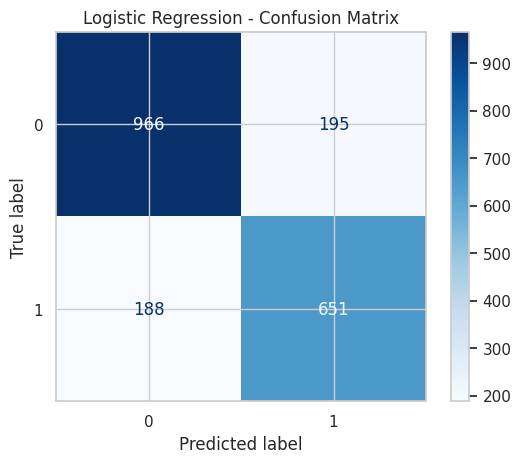



Random Forest Accuracy: 79.30%


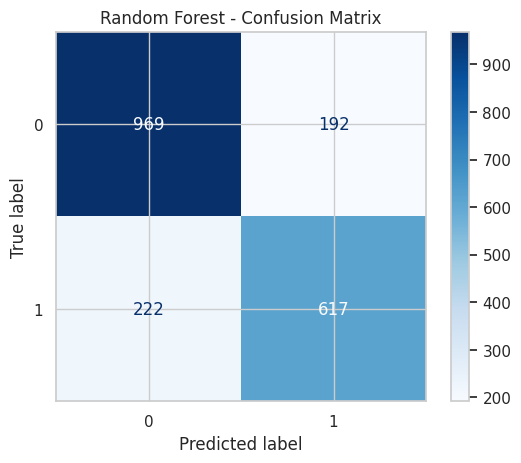



Decision Tree Accuracy: 77.75%


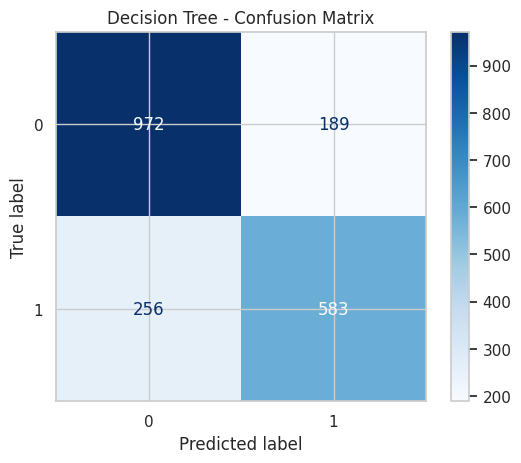



K-Nearest Neighbors Accuracy: 78.25%


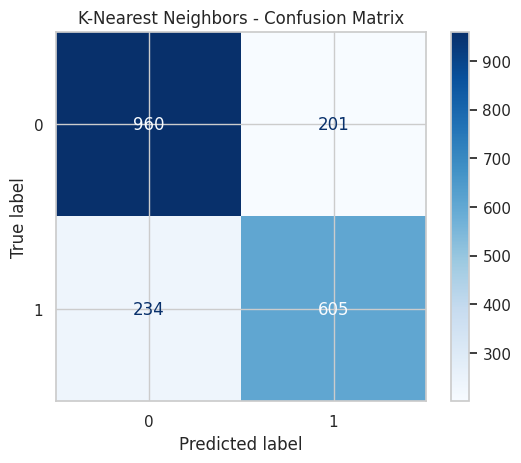



XGBoost Accuracy: 78.20%


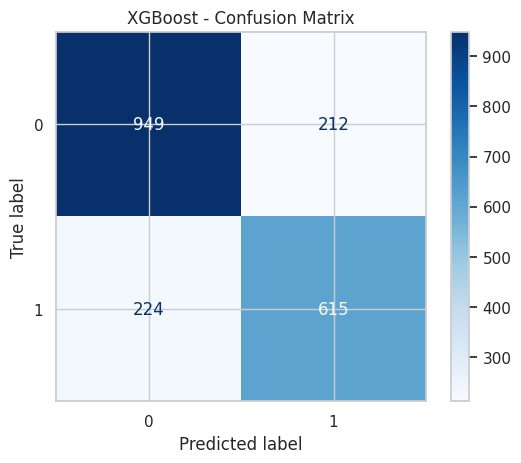



AdaBoost Accuracy: 80.50%


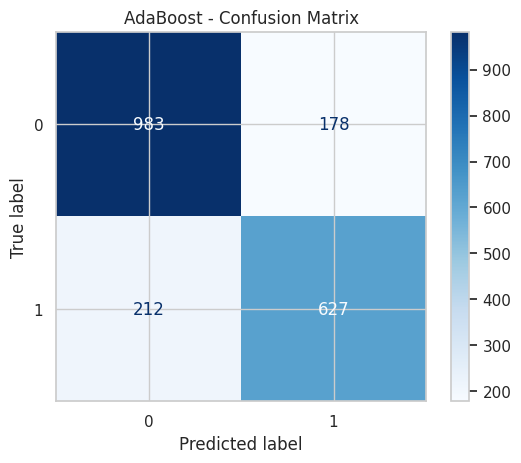



Gradient Boosting Accuracy: 78.40%


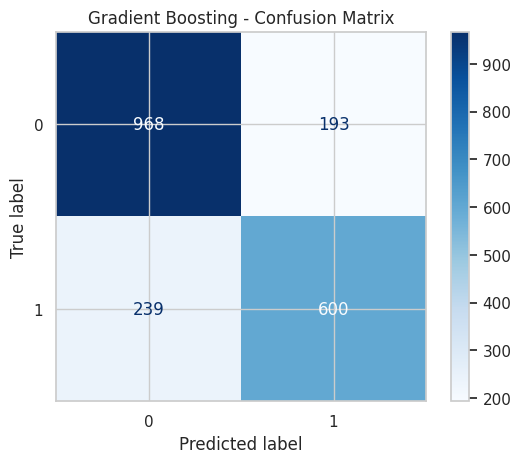

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

for model, name in models:
    # Predict on test data
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred) * 100
    print(f"{name} Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    print("\n")

In [56]:
from sklearn.model_selection import StratifiedKFold, cross_val_score # Added StratifiedKFold and cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCROSS-VALIDATION RESULTS (ROC-AUC)\n")

for model, name in models: # Corrected iteration for list 'models'
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc'
    )

    print(f"{name}")
    print(f"ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}\n")


CROSS-VALIDATION RESULTS (ROC-AUC)

Support Vector Machine
ROC-AUC: 0.8484 ± 0.0148

Logistic Regression
ROC-AUC: 0.8769 ± 0.0133

Random Forest
ROC-AUC: 0.8640 ± 0.0121

Decision Tree
ROC-AUC: 0.8419 ± 0.0144

K-Nearest Neighbors
ROC-AUC: 0.8448 ± 0.0161

XGBoost
ROC-AUC: 0.8531 ± 0.0151

AdaBoost
ROC-AUC: 0.8751 ± 0.0135

Gradient Boosting
ROC-AUC: 0.8519 ± 0.0119



### **DATA VISUALIZATION**

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)

sns.set(style="whitegrid")


In [57]:
def visualize_train_test(model, model_name, X_train, y_train, X_test, y_test):

    # Fit model
    model.fit(X_train, y_train)

    # Probabilities
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Predictions (default threshold)
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # ROC curves
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_prob)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_prob)

    auc_tr = auc(fpr_tr, tpr_tr)
    auc_te = auc(fpr_te, tpr_te)

    # ---------------- PLOTS ----------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix - Train
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{model_name} - Train CM")

    # Confusion Matrix - Test
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"{model_name} - Test CM")

    # ROC Curve
    axes[2].plot(fpr_tr, tpr_tr, label=f"Train AUC = {auc_tr:.2f}")
    axes[2].plot(fpr_te, tpr_te, label=f"Test AUC = {auc_te:.2f}")
    axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axes[2].set_title(f"{model_name} - ROC Curve")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend()

    plt.suptitle(
        f"{model_name} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%",
        fontsize=14
    )
    plt.show()


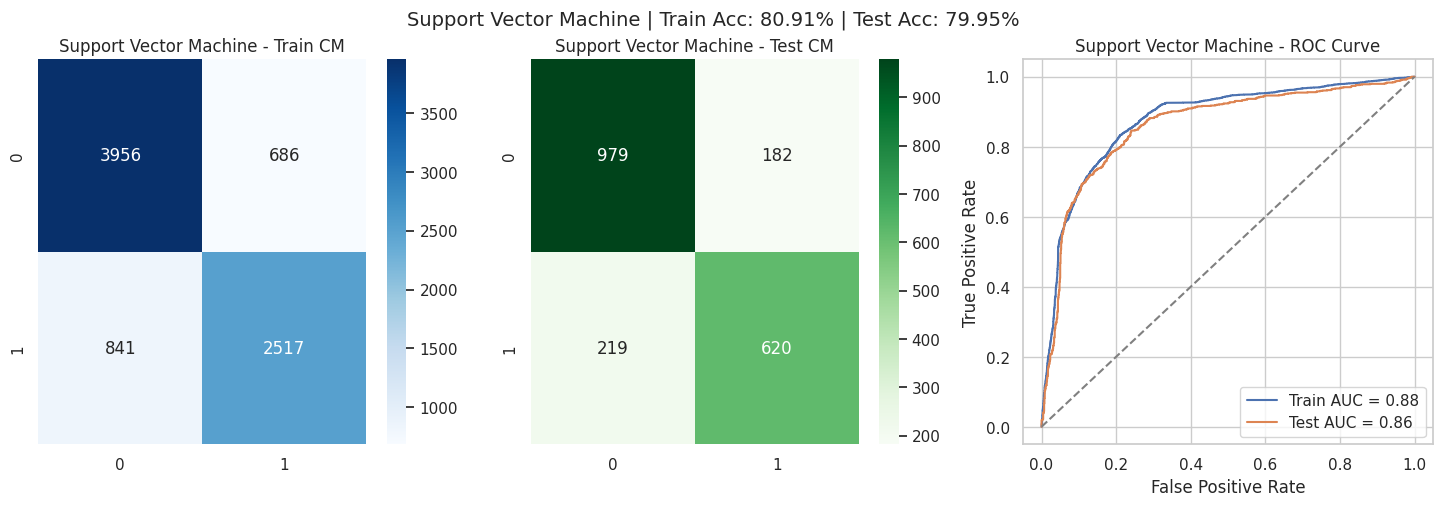

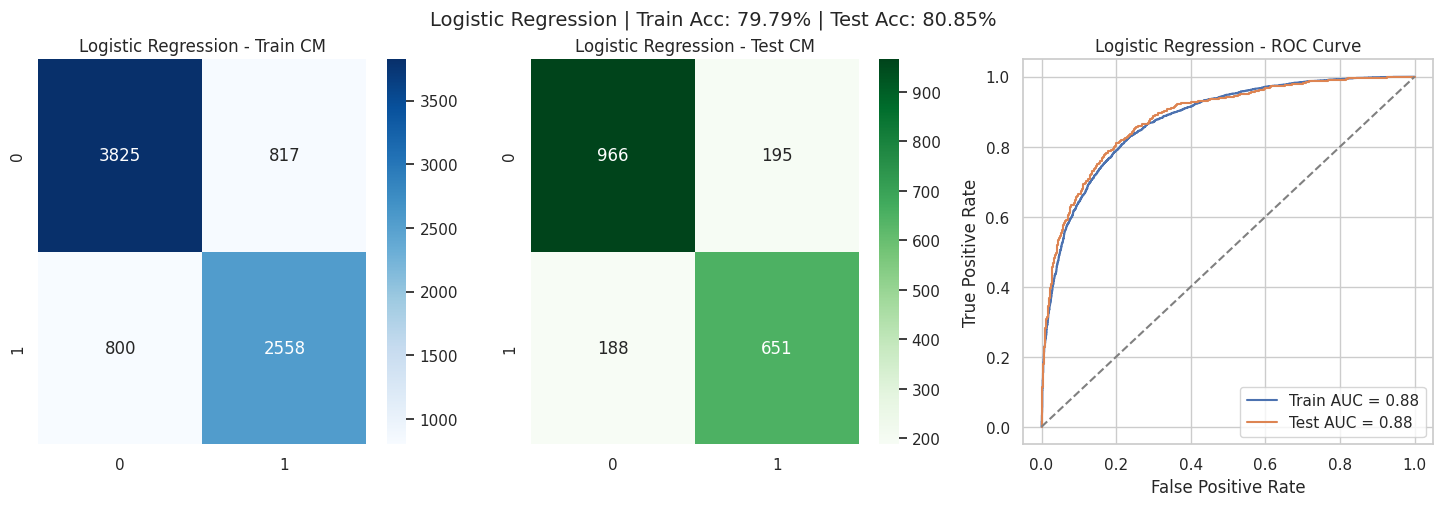

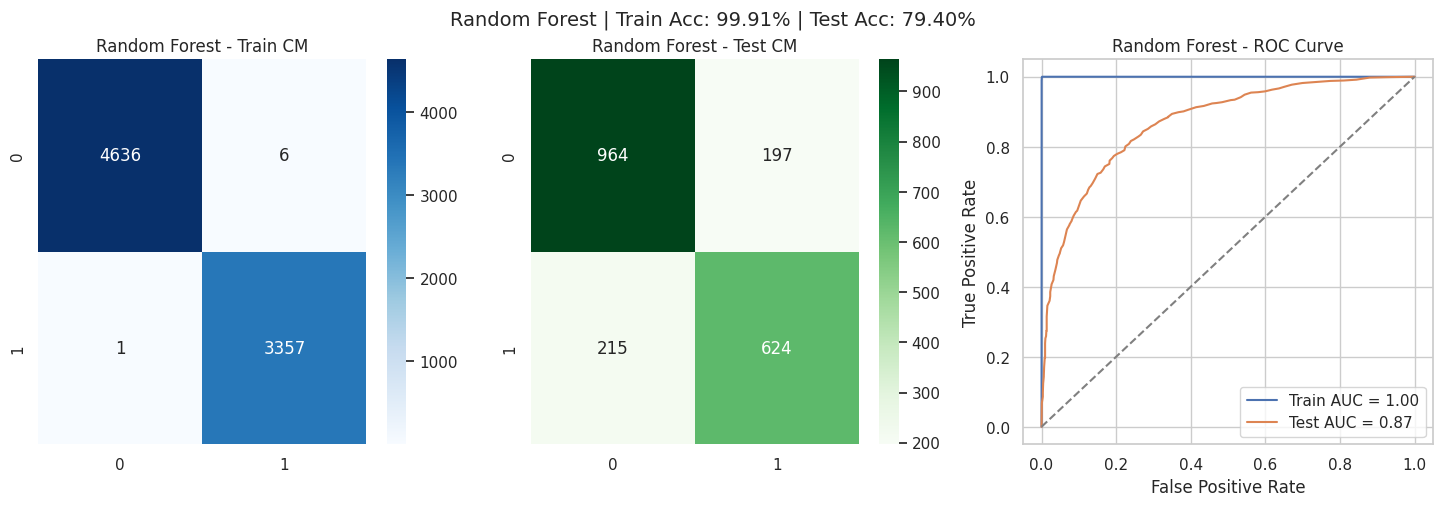

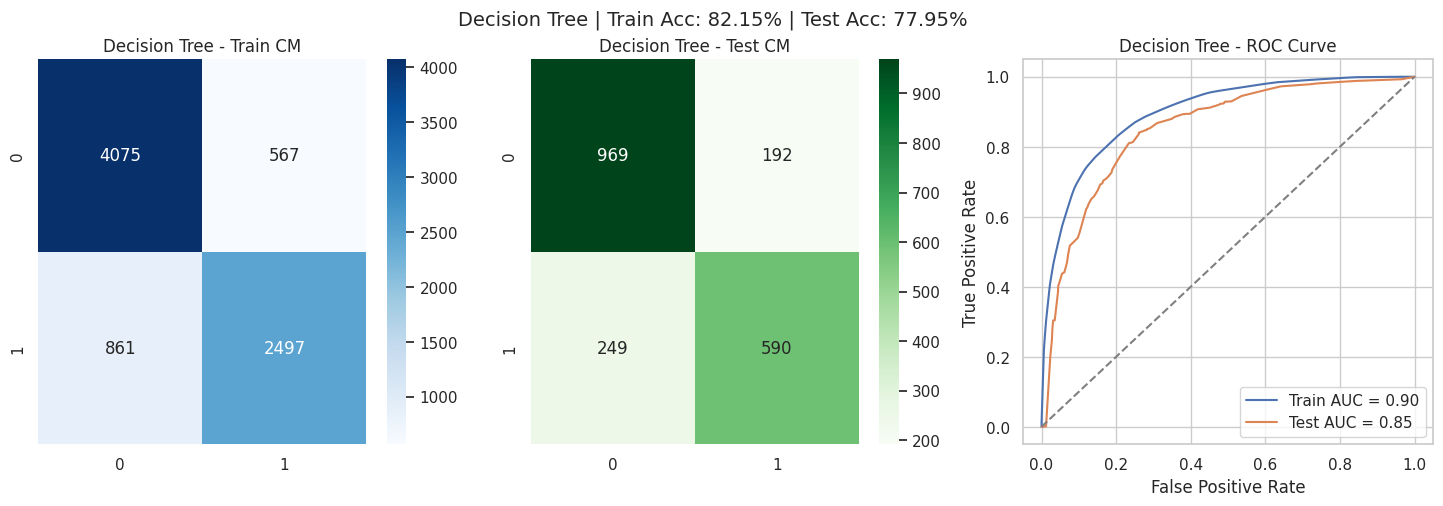

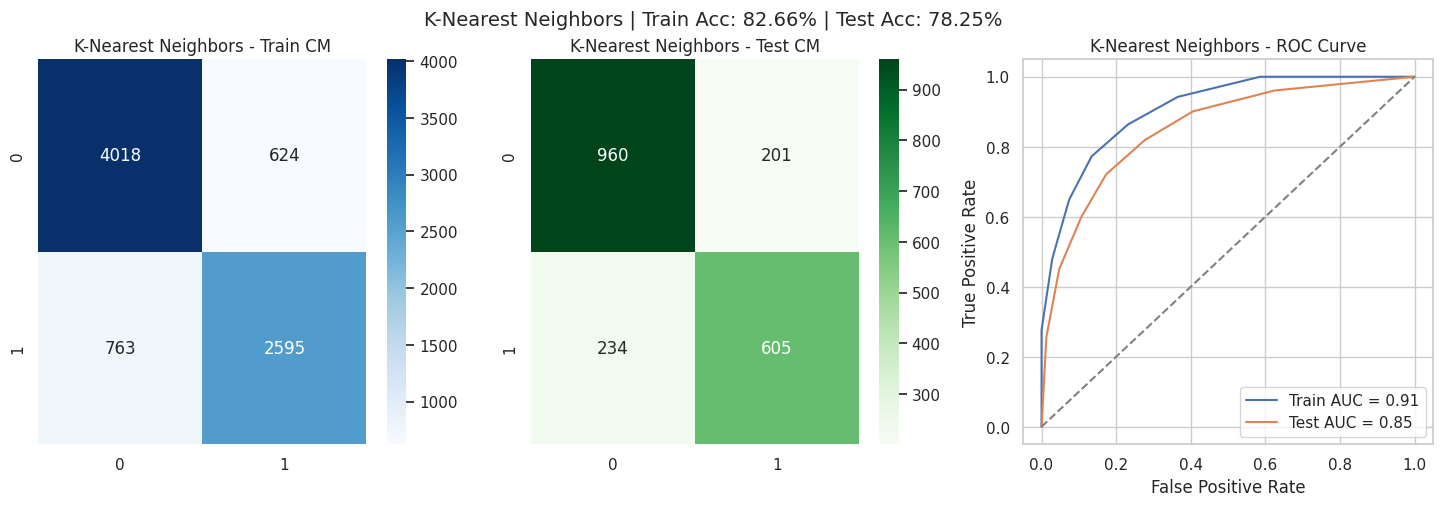

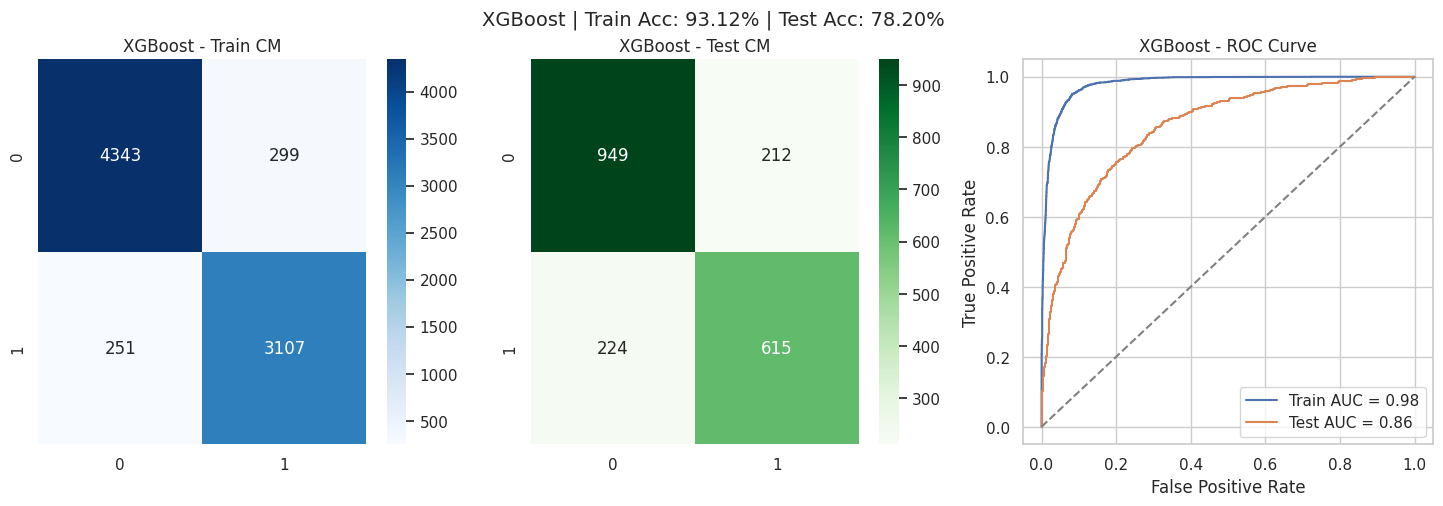

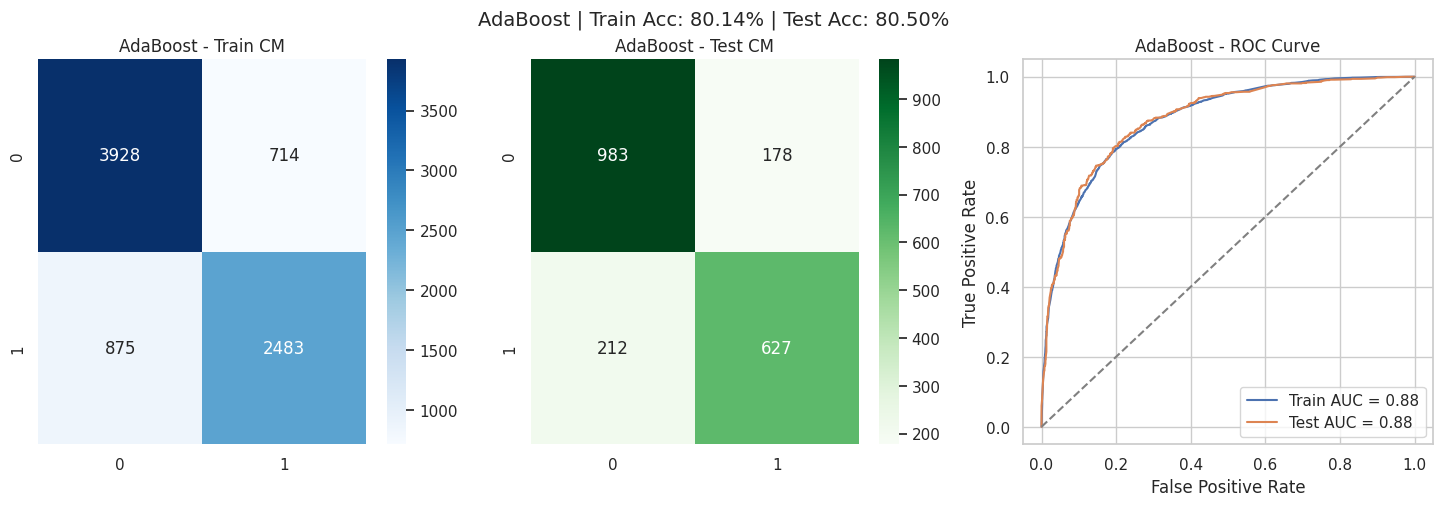

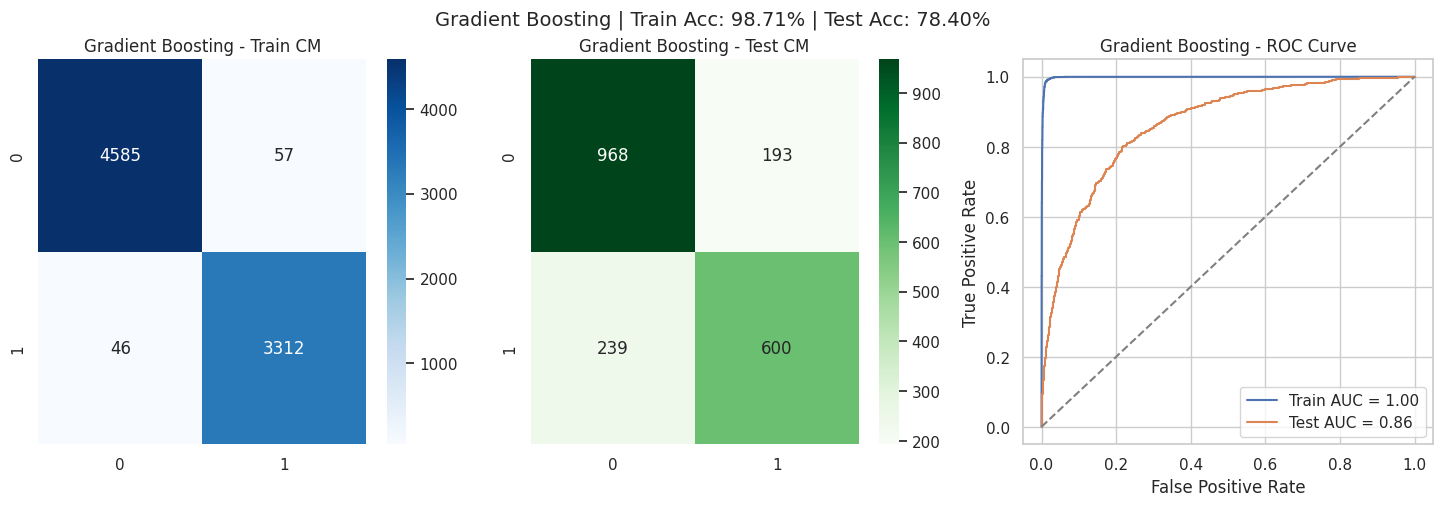

In [58]:
for model, name in models:
    visualize_train_test(
        model,
        name,
        X_train,
        y_train,
        X_test,
        y_test
    )

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:48:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


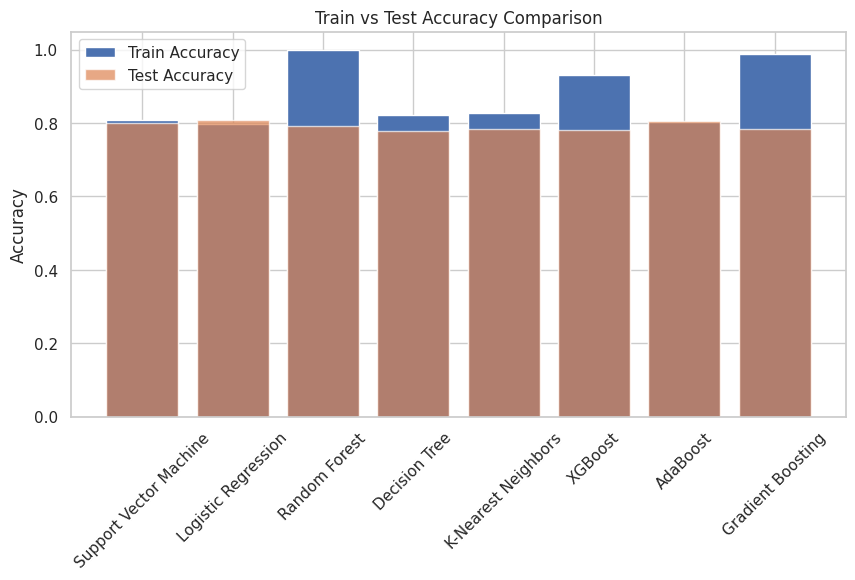

In [41]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accs = []
test_accs = []
model_names = []

for model, name in models:
    model.fit(X_train, y_train)
    train_accs.append(
        accuracy_score(y_train, model.predict(X_train))
    )
    test_accs.append(
        accuracy_score(y_test, model.predict(X_test))
    )
    model_names.append(name)

plt.figure(figsize=(10,5))
plt.bar(model_names, train_accs, label="Train Accuracy")
plt.bar(model_names, test_accs, label="Test Accuracy", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.show()